In [356]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

In [357]:
# Current script
current_path = os.getcwd()

# Add utils folder to sys path 
sys.path.append(os.path.join(current_path, "utils"))

# Import the prewritten helper functions
from py_helper_functions import *

# Data & Data Cleaning

In [358]:
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/DA3-Assignment-1/main/morg-2014-emp.csv")

In [359]:
data.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [360]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149316 entries, 0 to 149315
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  149316 non-null  int64  
 1   hhid        149316 non-null  int64  
 2   intmonth    149316 non-null  object 
 3   stfips      149316 non-null  object 
 4   weight      149316 non-null  float64
 5   earnwke     149316 non-null  float64
 6   uhours      149316 non-null  int64  
 7   grade92     149316 non-null  int64  
 8   race        149316 non-null  int64  
 9   ethnic      20071 non-null   float64
 10  age         149316 non-null  int64  
 11  sex         149316 non-null  int64  
 12  marital     149316 non-null  int64  
 13  ownchild    149316 non-null  int64  
 14  chldpres    149316 non-null  int64  
 15  prcitshp    149316 non-null  object 
 16  state       149316 non-null  object 
 17  ind02       149316 non-null  object 
 18  occ2012     149316 non-null  int64  
 19  cl

In [361]:
# Choosen occupation: Personal Care and Service Occupations (4300-4650)
data = data.loc[(data["occ2012"] >= 4300) & (data["occ2012"] <= 4650)]

# Create male, wage, lnwage variables

data["sex"] = (data["sex"] == 1)
data["w"] = data["earnwke"] / data["uhours"]
data["lnw"] = np.log(data["w"])

# grade92 True, if the person has an Associatedegree--occupational/vocational

data["grade92"] = (data["grade92"] >= 41)

# Create Union and Private, whether the person is union member and whether works for a private firm

data["unionmme"] = (data["unionmme"] == "Yes")

def has_private(text):
    return 'Private' in text

data["Private"] = data["class"].apply(has_private)

# race True, if the person is white

data["race"] = (data["race"] == 1)

# marital True, if the person is or has been married

data["marital"] = (data["marital"] != 7)

#prctship Ture, if the person is native in the USA

def native(text):
    return 'Native' in text

data["prcitshp"] = data["prcitshp"].apply(native)

# lfsr94 True, if the person is currently at work

def work(text):
    return 'Work' in text

data["lfsr94"] = data["lfsr94"].apply(work)


data

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,state,ind02,occ2012,class,unionmme,unioncov,lfsr94,w,lnw,Private
54,128,510365013001006,January,AL,2594.3007,400.00,20,True,True,NaN,...,63,Child day care services (6244),4600,"Private, Nonprofit",False,No,True,20.000000,2.995732,True
141,315,299350627300630,January,AK,415.4125,192.30,40,True,True,NaN,...,94,Child day care services (6244),4600,"Private, For Profit",False,No,False,4.807500,1.570177,True
207,476,299290794630670,January,AK,374.8012,1770.60,60,False,True,NaN,...,94,Administration of human resource programs (923),4610,Government - State,False,No,True,29.510000,3.384729,False
230,518,610923097503049,January,AK,448.3966,36.25,5,False,True,NaN,...,94,Elementary and secondary schools (6111),4600,"Private, Nonprofit",False,No,True,7.250000,1.981001,True
248,553,773019090200142,January,AK,589.5615,680.00,40,False,True,NaN,...,94,Other personal services (8129),4350,Government - Federal,False,No,True,17.000000,2.833213,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149078,316593,310001705119835,December,WI,3814.6828,345.00,30,True,True,NaN,...,3,Child day care services (6244),4600,"Private, For Profit",False,No,True,11.500000,2.442347,True
149136,316690,615640001130506,December,WI,2977.7663,1923.00,40,False,True,NaN,...,3,Beauty salons (812112),4510,"Private, For Profit",False,No,True,48.075000,3.872762,True
149194,316811,406604685991706,December,WY,266.6387,400.00,36,False,True,NaN,...,8,"Residential care facilities, without nursing (...",4610,"Private, For Profit",False,No,True,11.111111,2.407946,True
149287,316996,210005535615846,December,WY,258.6668,654.00,35,True,True,NaN,...,8,Beauty salons (812112),4510,"Private, For Profit",False,No,True,18.685714,2.927759,True


# DISTRIBUTION OF EARNINGS

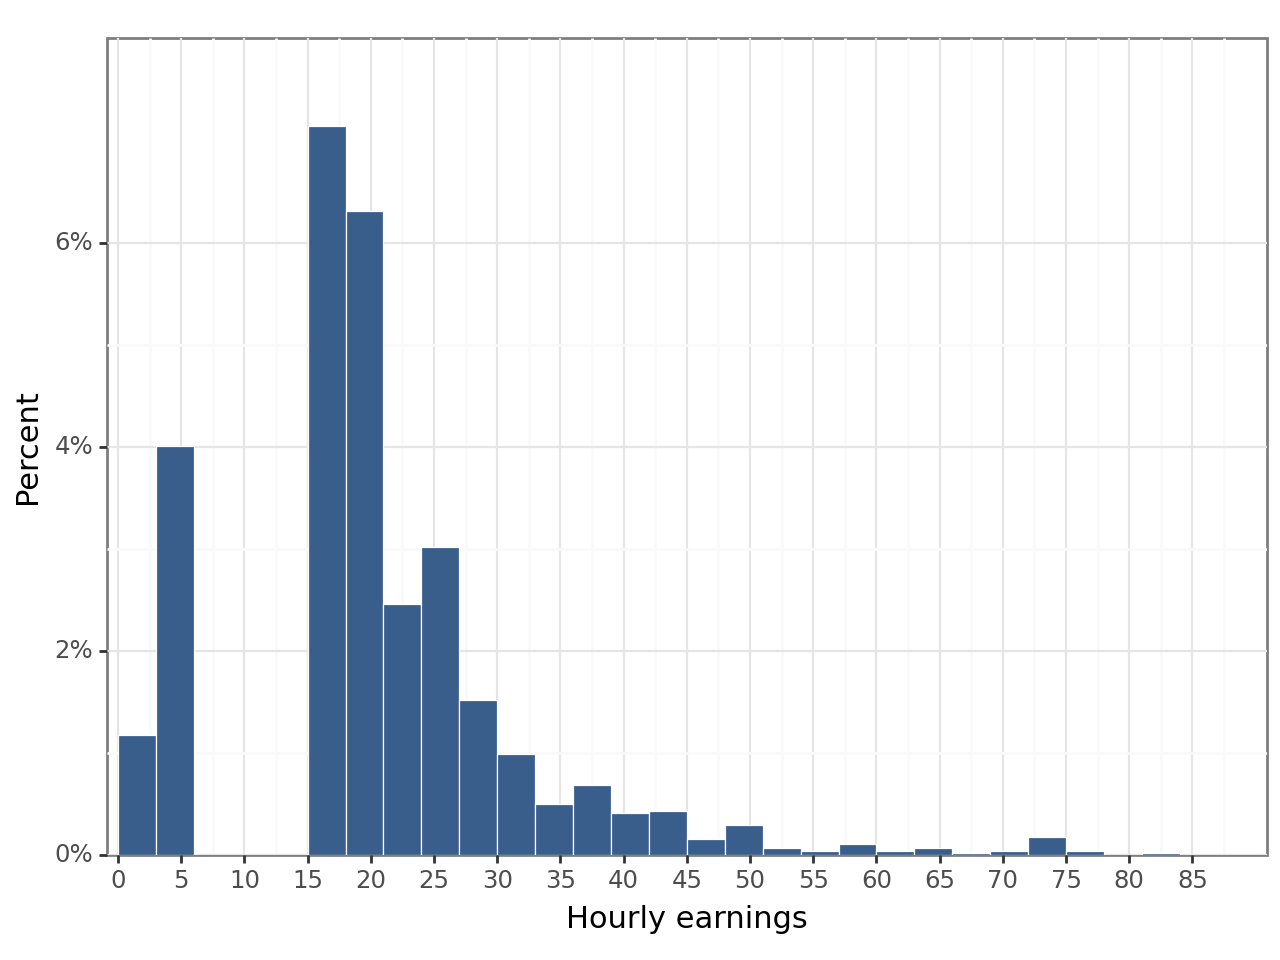

<Figure Size: (640 x 480)>

In [362]:
(
    ggplot(data, aes(x="w", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Hourly earnings", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 90), breaks=seq(0, 90, 5))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        breaks=seq(0, 0.08, 0.02),
        limits=(0, 0.08),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)


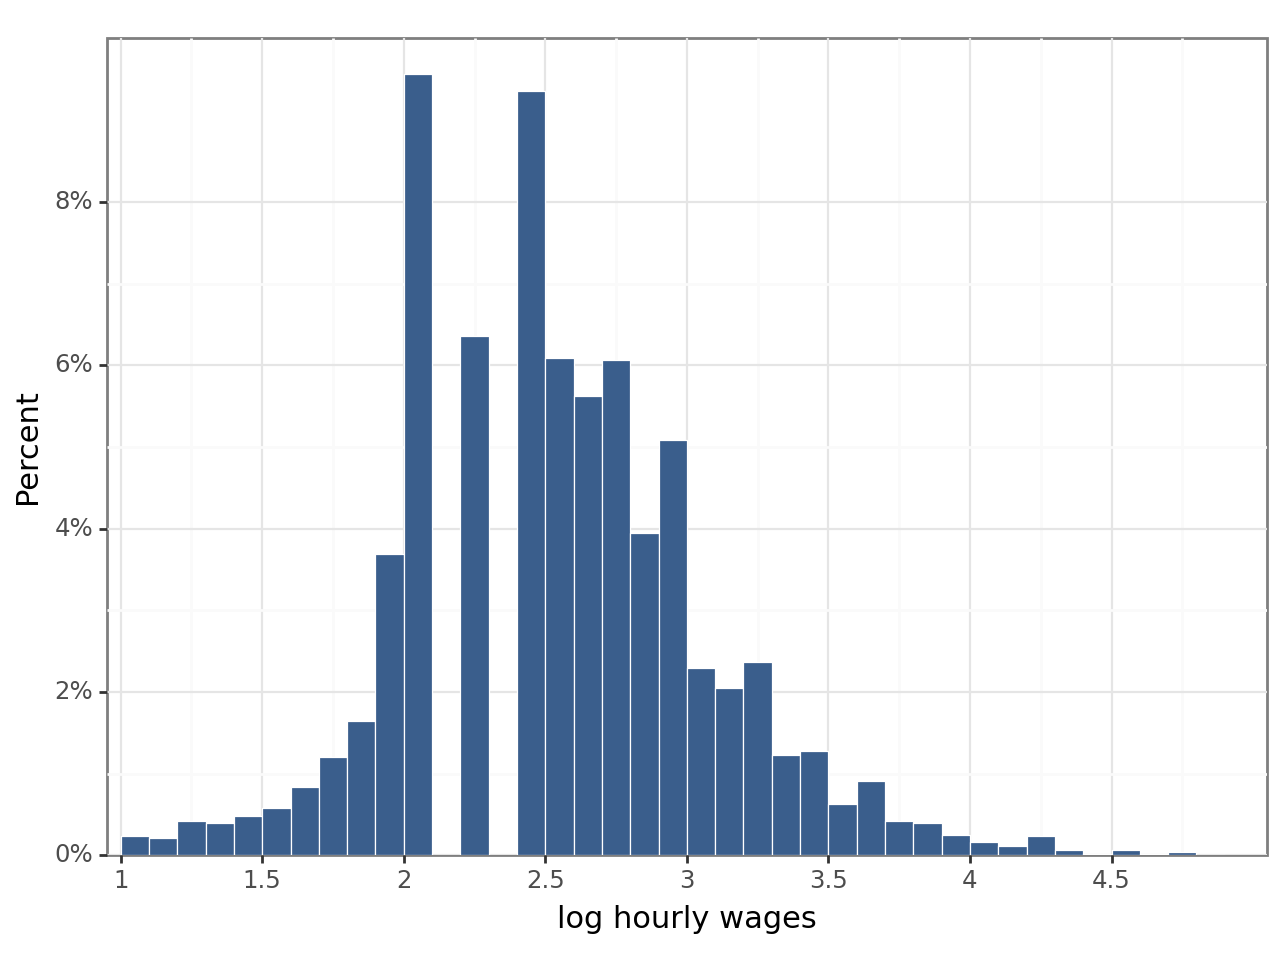

<Figure Size: (640 x 480)>

In [363]:
(
    ggplot(data, aes(x="lnw", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 5, 0.5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        breaks=seq(0, 0.1, 0.02),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)

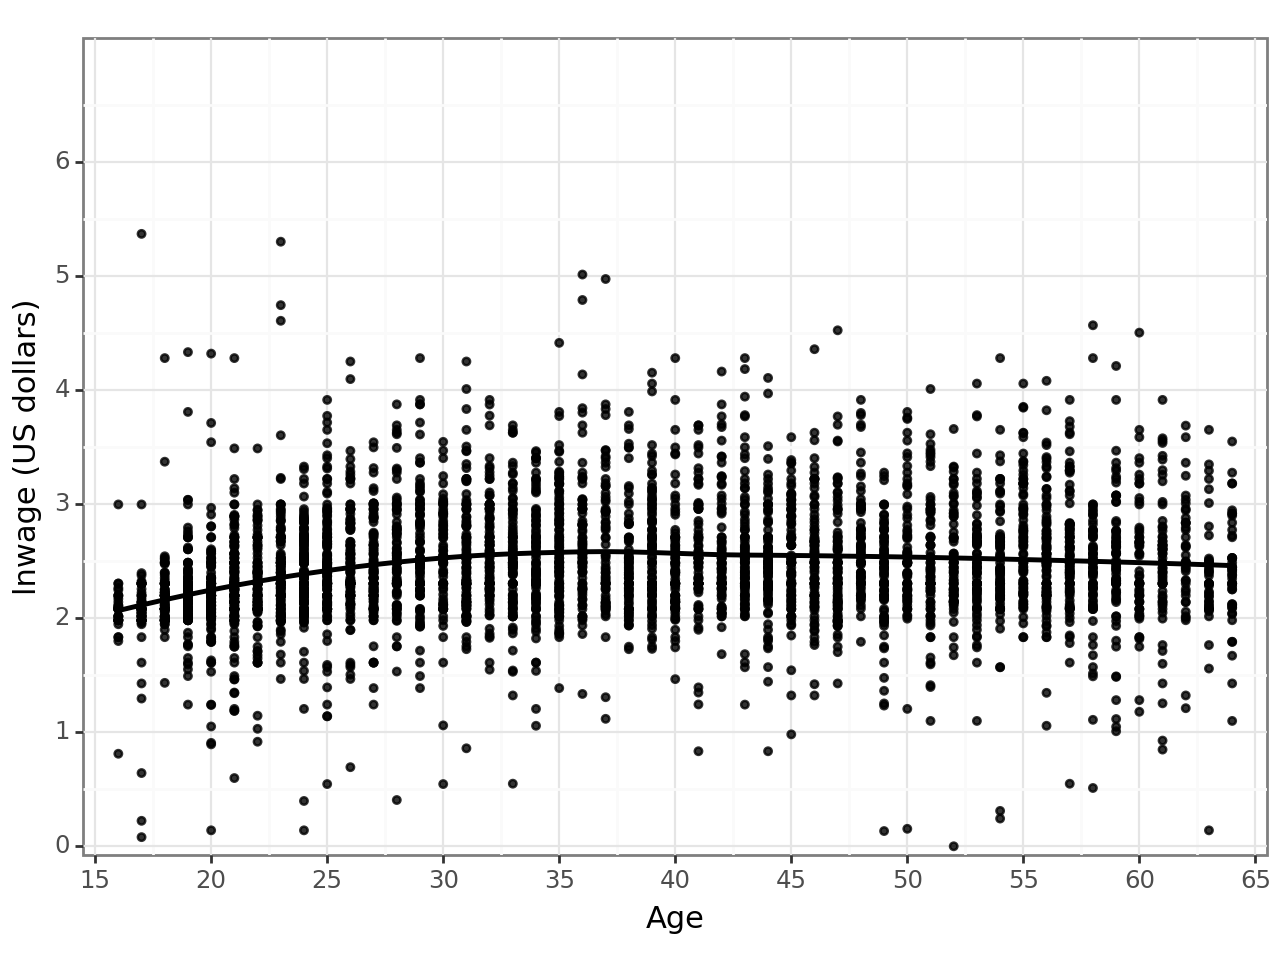

In [364]:
plot = ggplot(data, aes(x="age", y="lnw")) + geom_point(
    size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(method="loess", se=False, size=1, span=0.9) + labs(
    x="Age", y="lnwage (US dollars)"
) + theme_bw() + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7, 1)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(15, 65), breaks=np.arange(0, 70, 5)
)

print(plot)


# Modells

In [365]:
# Models for lnw:

formula1 = "w~age"
formula2 = "w~age+sex+grade92+marital+age:grade92"
formula3 = "w~age+sex+grade92+marital+race+ownchild+Private+age:grade92+ownchild:unionmme"
formula4 = "w~age+sex+grade92+marital+race+ownchild+Private+prcitshp+unionmme+lfsr94+age:grade92+age:ownchild+age:unionmme+ownchild:unionmme+ownchild:race"

# Model1:
reg1 = smf.ols(formula=formula1, data=data).fit(cov_type = "HC0")

# Model2:
reg2 = smf.ols(formula=formula2, data=data).fit(cov_type = "HC0")

# Model3:
reg3 = smf.ols(formula=formula3, data=data).fit(cov_type = "HC0")

# Model4:
reg4 = smf.ols(formula=formula4, data=data).fit(cov_type = "HC0")


In [366]:
bic = [round(x.bic, 2) for x in [reg1,reg2,reg3,reg4]]
sg = stargazer.Stargazer([reg1,reg2,reg3,reg4])
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)

sg

In [367]:
print(sg.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable: w}} \
\cr \cline{2-5}
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Intercept & 10.769$^{***}$ & 9.456$^{***}$ & 9.284$^{***}$ & 10.132$^{***}$ \\
& (0.466) & (0.537) & (0.951) & (1.494) \\
 Private[T.True] & & & -0.455$^{}$ & -0.292$^{}$ \\
& & & (0.608) & (0.636) \\
 age & 0.076$^{***}$ & 0.044$^{***}$ & 0.049$^{***}$ & 0.049$^{***}$ \\
& (0.011) & (0.014) & (0.015) & (0.016) \\
 age:grade92[T.True] & & -0.008$^{}$ & -0.008$^{}$ & -0.006$^{}$ \\
& & (0.026) & (0.026) & (0.025) \\
 age:ownchild & & & & -0.009$^{}$ \\
& & & & (0.013) \\
 age:unionmme[T.True] & & & & 0.007$^{}$ \\
& & & & (0.042) \\
 grade92[T.True] & & 3.712$^{***}$ & 3.713$^{***}$ & 3.668$^{***}$ \\
& & (1.049) & (1.051) & (1.051) \\
 lfsr94[T.True] & & & & -1.047$^{}$ \\
& & & & (0.995) \\
 marital[T.True] & & 1.343$^{***}$ & 1.156$^{***}$ & 1.131$^{

# Modell RMSE full sample

In [368]:
#get models rmse

print("Model 1:", rmse(reg1.fittedvalues,data.w))
print("Model 2:", rmse(reg2.fittedvalues,data.w))
print("Model 3:", rmse(reg3.fittedvalues,data.w))
print("Model 4:", rmse(reg4.fittedvalues,data.w))

Model 1: 10.209360676188265
Model 2: 9.990962087286785
Model 3: 9.985220830785064
Model 4: 9.978600826062083


# Modell RMSE cross-validation

In [369]:
from sklearn.model_selection import KFold
k = KFold(n_splits=4, shuffle=True, random_state=None)

In [370]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula


def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [371]:
cv1 = cv_reg(formula1, data, k, "HC0")
cv2 = cv_reg(formula2, data, k, "HC0")
cv3 = cv_reg(formula3, data, k, "HC0")
cv4 = cv_reg(formula4, data, k,"HC0")
cv_list = [cv1, cv2, cv3, cv4]

In [372]:
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4
Fold1,9.994657,10.376396,10.201266,10.289894
Fold2,10.811281,10.340119,10.181047,9.861922
Fold3,9.314395,9.608586,10.174534,9.456408
Fold4,10.643370,9.600842,9.349573,10.260475
Average,10.190926,9.981486,9.976605,9.967175
